# Predicting House Sale Prices

## Introduction

In this project, we will apply a linear regression model and use different features of model fitting and feature engineering to optimize the model we build.

We will work with housing data for the city of Ames, Iowa, USA from 2006 to 2010. This dataset contains 2930 observations that describe the sale of individual residential properties. You can read more about the dataset [here](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627]) and read about the different columns in the data [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

Let's start by setting up a pipeline of functions that will quickly let us iterate on different models. We will create a function to transform features, select features, and finally train and test.

In [1]:
import pandas as pd
pd.options.display.max_columns = 999
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv('AmesHousing.tsv',delimiter='\t') #Import data

In [3]:
#Create transform_feature function

def transform_features(df):
    return df

In [4]:
#Create select_feature function

def select_features(df):
    return df[['Gr Liv Area','SalePrice']]

In [5]:
#Create train and test function

def train_and_test(df):
    train = df[:1460]
    test = df[1460:]
    
    ##Use pd.DataFrame.select_dtypes() to specify column types
    numeric_train = train.select_dtypes(include=['integer','float'])
    numeric_test = test.select_dtypes(include=['int','float'])
    
    features = numeric_train.columns.drop('SalePrice')
        
    lr = LinearRegression()
    lr.fit(train[features],train['SalePrice'])
    
    test_predictions = lr.predict(test[features])
    test_rmse = mean_squared_error(test['SalePrice'],test_predictions)**0.5
    
    return test_rmse

## Feature Engineering

Let's start removing features with many missing values, and then transform columns with few missing values.

We will first create the code to modify the dataframe, then move this code into our transform_features() function.


### Removing null values
1. Drop any column from the data frame with more than 5% values **for now**
2. For text columns with 1 or more missing values **for now**
3. For numerical columns with less than 5% missing values, replace null values with the column's most popular value (the mode) **for now**


In [6]:
# 1. Drop any column with greater than 5% missing values

df_nulls = df.isnull().sum()

num_missing = int(len(df)*0.05)
df_nulls_gr_5 = df_nulls[df_nulls > num_missing].index
df = df.drop(df_nulls_gr_5,axis = 1)

In [7]:
df.isnull().sum().value_counts()

0     55
1      7
80     3
23     2
2      2
83     1
81     1
dtype: int64

In [8]:
# 2. Drop any text column with any missing value

df_text_nulls = df.select_dtypes(include = ['object']).isnull().sum()
df_text_nulls_cols = df_text_nulls[df_text_nulls > 0].index
df = df.drop(df_text_nulls_cols,axis = 1)

In [9]:
df.isnull().sum().value_counts()

0     55
1      6
2      2
23     1
dtype: int64

In [10]:
# 3. Transform numerical columns with less than 5% missing values
#    with the mode of the column
less_than_5 = int(len(df)*0.05)
df_num_nulls = df.select_dtypes(include=['integer','float']).isnull().sum()
df_less5_cols = df_num_nulls[(df_num_nulls < less_than_5) & (df_num_nulls != 0)]
df_less5_cols


Mas Vnr Area      23
BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Bsmt Full Bath     2
Bsmt Half Bath     2
Garage Cars        1
Garage Area        1
dtype: int64

In [11]:
replacement_values_dict = df[df_less5_cols.index].mode().to_dict(orient='records')[0]
replacement_values_dict

{'Mas Vnr Area': 0.0,
 'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Bsmt Unf SF': 0.0,
 'Total Bsmt SF': 0.0,
 'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Garage Cars': 2.0,
 'Garage Area': 0.0}

In [12]:
df=df.fillna(replacement_values_dict)


In [13]:
df.isnull().sum().value_counts()

0    64
dtype: int64

After removing null values, we are left with 64 columns with no null values. 

Let's now see if we can create additional features

### Creating new features

We can calculate the age of a home by subtracting year built from year sold.

We can also calculate years since remodel using the same logic

In [14]:
df['house age'] = df['Yr Sold']-df['Year Built']
df[df['house age'] < 0]

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,house age
2180,2181,908154195,20,RL,39290,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,1224.0,Ex,TA,PConc,4010.0,0.0,1085.0,5095.0,GasA,Ex,Y,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,3.0,1154.0,Y,546,484,0,0,0,0,17000,10,2007,New,Partial,183850,-1


In [15]:
df['years since remodel'] = df['Yr Sold'] - df['Year Remod/Add']
df[df['years since remodel'] < 0]

,Order,PID,MS SubClass,MS Zoning,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,house age,years since remodel
1702,1703,528120010,60,RL,16659,Pave,IR1,Lvl,AllPub,Corner,Gtl,NridgHt,Norm,Norm,1Fam,2Story,8,5,2007,2008,Gable,CompShg,VinylSd,VinylSd,0.0,Gd,TA,PConc,0.0,0.0,1582.0,1582.0,GasA,Ex,Y,1582,570,0,2152,0.0,0.0,2,1,3,1,Gd,7,Typ,1,2.0,728.0,Y,0,368,0,0,0,0,0,6,2007,New,Partial,260116,0,-1
2180,2181,908154195,20,RL,39290,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,10,5,2008,2009,Hip,CompShg,CemntBd,CmentBd,1224.0,Ex,TA,PConc,4010.0,0.0,1085.0,5095.0,GasA,Ex,Y,5095,0,0,5095,1.0,1.0,2,1,2,1,Ex,15,Typ,2,3.0,1154.0,Y,546,484,0,0,0,0,17000,10,2007,New,Partial,183850,-1,-2
2181,2182,908154205,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,762.0,Ex,TA,PConc,2260.0,0.0,878.0,3138.0,GasA,Ex,Y,3138,1538,0,4676,1.0,0.0,3,1,3,1,Ex,11,Typ,1,3.0,884.0,Y,208,406,0,0,0,0,0,10,2007,New,Partial,184750,0,-1


There are some observations that have a negative value for house age and years since remodel. Since this is not possible, lets drop these 3 rows.

In [16]:
#Drop rows with negative values for our new metrics
df = df.drop([1702,2180,2181],axis=0)

#Drop Year Built and Remodel now that we have new metrics
df = df.drop(['Year Built','Year Remod/Add'],axis=1)

### Dropping Columns not useful for machine learning

Let's finish our transformation by dropping columns that overall arent useful for machine learning, as well as columns that leak data about the final sale

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 64 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Order                2927 non-null   int64  
 1   PID                  2927 non-null   int64  
 2   MS SubClass          2927 non-null   int64  
 3   MS Zoning            2927 non-null   object 
 4   Lot Area             2927 non-null   int64  
 5   Street               2927 non-null   object 
 6   Lot Shape            2927 non-null   object 
 7   Land Contour         2927 non-null   object 
 8   Utilities            2927 non-null   object 
 9   Lot Config           2927 non-null   object 
 10  Land Slope           2927 non-null   object 
 11  Neighborhood         2927 non-null   object 
 12  Condition 1          2927 non-null   object 
 13  Condition 2          2927 non-null   object 
 14  Bldg Type            2927 non-null   object 
 15  House Style          2927 non-null   o

In [18]:
#drop columns not useful for ML
df = df.drop(['PID','Order'],axis = 1)

#drop columns that leak information about the sale
df = df.drop(['Mo Sold','Yr Sold','Sale Type','Sale Condition'],axis=1)

Now that we have cleaned our original dataset, lets update transform_features

In [19]:
def transform_features(df):
    #Calculate null values of each column
    df_nulls = df.isnull().sum()
    
    #Drop columns with > 5% missing values
    five_pct_missing = int(len(df)*0.05)
    df_nulls_gr_5 = df_nulls[df_nulls > five_pct_missing].sort_values()
    df = df.drop(df_nulls_gr_5.index,axis = 1)
    
    #Drop any text columns with any missing values
    df_text_nulls = df.select_dtypes(include = ['object']).isnull().sum().sort_values(ascending=False)
    df_text_nulls_cols = df_text_nulls[df_text_nulls > 0]
    df = df.drop(df_text_nulls_cols.index,axis = 1)
    
    #With numeric values with less than 5% missing values, fill with the mode
    df_num_nulls = df.select_dtypes(include=['int64','float64']).isnull().sum()
    df_less5_cols = df_num_nulls[(df_num_nulls < five_pct_missing) & (df_num_nulls > 0)].sort_values()
    replacement_values_dict = df[df_less5_cols.index].mode().to_dict(orient='records')[0]
    df=df.fillna(replacement_values_dict)
    
    #Create new features using old features, and delete old features used
    df['house age'] = df['Yr Sold']-df['Year Built']
    df['years since remodel'] = df['Yr Sold'] - df['Year Remod/Add']
    
        ##Drop rows with negative values for our new metrics
    df = df.drop([1702,2180,2181],axis=0)
    
    #drop columns not useful for ML and those that
    df = df.drop(['PID','Order','Mo Sold','Yr Sold','Sale Type','Sale Condition','Year Built','Year Remod/Add'],axis = 1)

    return df

def select_features(df):
    return df[['Gr Liv Area','SalePrice']]

def train_and_test(df):
    train = df[:1460]
    test = df[1460:]
    
    ##Use pd.DataFrame.select_dtypes() to specify column types
    numeric_train = train.select_dtypes(include=['integer','float'])
    numeric_test = test.select_dtypes(include=['int','float'])
    
    features = numeric_train.columns.drop('SalePrice')
        
    lr = LinearRegression()
    lr.fit(train[features],train['SalePrice'])
    
    test_predictions = lr.predict(test[features])
    test_rmse = mean_squared_error(test['SalePrice'],test_predictions)**0.5
    
    return test_rmse

df = pd.read_csv('AmesHousing.tsv',delimiter='\t')
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

## Feature Selection

Now that we have cleaned and transformed many of the features in the dataset, lets move on to selecting numerical features.

We'll first build a correlation heatmap matrix of the numerical features in the training dataset to find which features correlate strongly with our target column, SalePrice.

C:\Users\u6077541\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


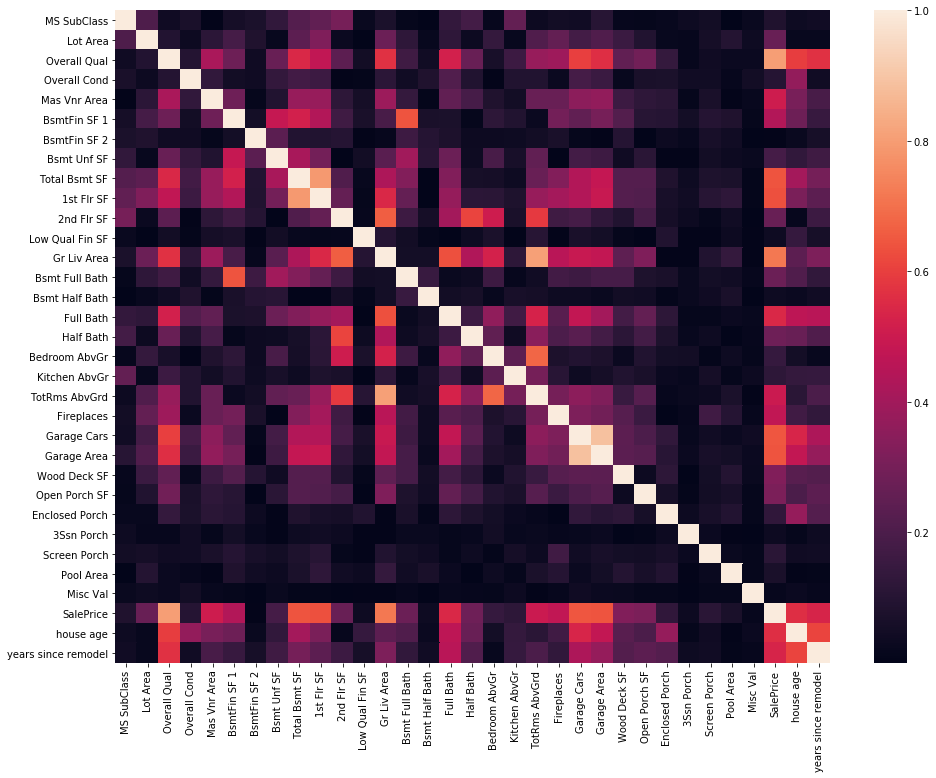

In [20]:
import seaborn as sns

df_num = transform_df.select_dtypes(include=['int64','float64'])

plt.figure(figsize = (16,12))
ax = sns.heatmap(df_num.corr().abs())

We took the absolute value of our correlation values because we care about if features have a strong correlation to SalePrice, but we do not care if it is positively or negatively correlated.

From our heatmap we see several features that correlate strongly with SalePrice:

- Overall Qual
- Gr Liv Area
- Garage Cars
- Total Bsmt SF
- Garage Area
- 1st Flr SF
- house age
- Full Bath
- years since remod
- Mas Vnr Area
- TotRms AbvGrd
- Fireplaces
- BsmtFin SF 1

Let's keep columns with a correlation coefficient of 0.4 or higher and examine which features have the strongest correlation more closely.

In [21]:
saleprice_corr = transform_df.corr().abs()['SalePrice']
strong_corr = saleprice_corr[saleprice_corr > 0.4].sort_values(ascending=False)
strong_corr

SalePrice              1.000000
Overall Qual           0.801206
Gr Liv Area            0.717596
Garage Cars            0.648361
Total Bsmt SF          0.644012
Garage Area            0.641425
1st Flr SF             0.635185
house age              0.558979
Full Bath              0.546118
years since remodel    0.534985
Mas Vnr Area           0.506983
TotRms AbvGrd          0.498574
Fireplaces             0.474831
BsmtFin SF 1           0.439284
Name: SalePrice, dtype: float64

In [22]:
transform_df = transform_df.drop(saleprice_corr[saleprice_corr < 0.4].index,axis=1)
transform_df.head(5)

,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,BsmtFin SF 1,Total Bsmt SF,Heating,Heating QC,Central Air,1st Flr SF,Gr Liv Area,Full Bath,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,SalePrice,house age,years since remodel
0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,Hip,CompShg,BrkFace,Plywood,112.0,TA,TA,CBlock,639.0,1080.0,GasA,Fa,Y,1656,1656,1,TA,7,Typ,2,2.0,528.0,P,215000,50,50
1,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,CBlock,468.0,882.0,GasA,TA,Y,896,896,1,TA,5,Typ,0,1.0,730.0,Y,105000,49,49
2,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,Hip,CompShg,Wd Sdng,Wd Sdng,108.0,TA,TA,CBlock,923.0,1329.0,GasA,TA,Y,1329,1329,1,Gd,6,Typ,0,1.0,312.0,Y,172000,52,52
3,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,Hip,CompShg,BrkFace,BrkFace,0.0,Gd,TA,CBlock,1065.0,2110.0,GasA,Ex,Y,2110,2110,2,Ex,8,Typ,2,2.0,522.0,Y,244000,42,42
4,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,PConc,791.0,928.0,GasA,Gd,Y,928,1629,2,TA,6,Typ,1,2.0,482.0,Y,189900,13,12


We have several features that are meant to be categorical. All columns that can be categorized as nominal variables are candidates for being converted to categorical as well.

Let's create a list of all the columns meant to be categorical according to the dataset documentation above and decide which features should be kept and converted to the categorical datatype.

In [23]:
categorical_cols = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

In [24]:
cat_cols_to_transform = []

for col in categorical_cols:
    if col in transform_df.columns:
        cat_cols_to_transform.append(col)

cat_cols_to_transform

['MS Zoning',
 'Street',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Foundation',
 'Heating',
 'Central Air']

In [25]:
cat_cols_df = transform_df[cat_cols_to_transform]
cat_cols_df

,MS Zoning,Street,Land Contour,Lot Config,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Foundation,Heating,Central Air
0,RL,Pave,Lvl,Corner,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,BrkFace,Plywood,CBlock,GasA,Y
1,RH,Pave,Lvl,Inside,NAmes,Feedr,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,CBlock,GasA,Y
2,RL,Pave,Lvl,Corner,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,Wd Sdng,Wd Sdng,CBlock,GasA,Y
3,RL,Pave,Lvl,Corner,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,BrkFace,BrkFace,CBlock,GasA,Y
4,RL,Pave,Lvl,Inside,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,PConc,GasA,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,RL,Pave,Lvl,CulDSac,Mitchel,Norm,Norm,1Fam,SLvl,Gable,CompShg,HdBoard,HdBoard,CBlock,GasA,Y
2926,RL,Pave,Low,Inside,Mitchel,Norm,Norm,1Fam,1Story,Gable,CompShg,HdBoard,HdBoard,CBlock,GasA,Y
2927,RL,Pave,Lvl,Inside,Mitchel,Norm,Norm,1Fam,SFoyer,Gable,CompShg,HdBoard,Wd Shng,PConc,GasA,Y
2928,RL,Pave,Lvl,Inside,Mitchel,Norm,Norm,1Fam,1Story,Gable,CompShg,HdBoard,HdBoard,CBlock,GasA,Y


How many different categories exist for each feature? 

We want to keep features that do not have too many categories, as when we dummy code the feature, hundreds of columns will be added back to the dataframe.

We also want to remove columns that have low variance. This means if a categorical column has few unique values but more than 95% of the values in the column belong in a specific category, we want to remove this column.

Let's first remove any columns that have > 10 unique values

In [26]:
unique_cat_cols = cat_cols_df.nunique().sort_values()
unique_cat_cols

Street           2
Central Air      2
Land Contour     4
Lot Config       5
Bldg Type        5
Roof Style       6
Foundation       6
Heating          6
MS Zoning        7
Condition 2      8
House Style      8
Roof Matl        8
Condition 1      9
Exterior 1st    16
Exterior 2nd    17
Neighborhood    28
dtype: int64

In [27]:
transform_df = transform_df.drop(unique_cat_cols[unique_cat_cols >10].index,axis=1)

For the categorical columns remaining, lets examine which columns have low variance

In [28]:
cat_cols_to_transform = []

for col in categorical_cols:
    if col in transform_df.columns:
        cat_cols_to_transform.append(col)

cat_cols_df = transform_df[cat_cols_to_transform]

#Create frequency table of the remaining categorical columns
low_var_cats = []
for col in cat_cols_df.columns:
    top_freq = cat_cols_df[col].value_counts(normalize=True).sort_values(ascending=False)[0]
    if top_freq > 0.95:
        low_var_cats.append(col)

low_var_cats

['Street', 'Condition 2', 'Roof Matl', 'Heating']

Street, Condition 2, Roof Matl, and Heating all have low variance, with > 95% of all values belonging to one category. Let's remove these columns from our dataset

In [29]:
transform_df = transform_df.drop(low_var_cats,axis = 1)

Now that we have our desired categorical columns remaining, lets take the remaining text columns create our categorical columns

In [30]:
text_cols = transform_df.select_dtypes(include = ['object'])

for col in text_cols:
    transform_df[col] = transform_df[col].astype('category')

transform_df = pd.concat([transform_df,
                          pd.get_dummies(transform_df.select_dtypes(include=['category']))
                         ],axis = 1).drop(text_cols,axis=1)

Now we need to update our select_features() function with the actions we just performed

In [31]:
def transform_features(df):
    #Calculate null values of each column
    df_nulls = df.isnull().sum()
    
    #Drop columns with > 5% missing values
    five_pct_missing = int(len(df)*0.05)
    df_nulls_gr_5 = df_nulls[df_nulls > five_pct_missing].sort_values()
    df = df.drop(df_nulls_gr_5.index,axis = 1)
    
    #Drop any text columns with any missing values
    df_text_nulls = df.select_dtypes(include = ['object']).isnull().sum().sort_values(ascending=False)
    df_text_nulls_cols = df_text_nulls[df_text_nulls > 0]
    df = df.drop(df_text_nulls_cols.index,axis = 1)
    
    #With numeric values with less than 5% missing values, fill with the mode
    df_num_nulls = df.select_dtypes(include=['int64','float64']).isnull().sum()
    df_less5_cols = df_num_nulls[(df_num_nulls < five_pct_missing) & (df_num_nulls > 0)].sort_values()
    replacement_values_dict = df[df_less5_cols.index].mode().to_dict(orient='records')[0]
    df=df.fillna(replacement_values_dict)
    
    #Create new features using old features, and delete old features used
    df['house age'] = df['Yr Sold']-df['Year Built']
    df['years since remodel'] = df['Yr Sold'] - df['Year Remod/Add']
    
        ##Drop rows with negative values for our new metrics
    df = df.drop([1702,2180,2181],axis=0)
    
    #drop columns not useful for ML and those that
    df = df.drop(['PID','Order','Mo Sold','Yr Sold','Sale Type','Sale Condition','Year Built','Year Remod/Add'],axis = 1)

    return df

def select_features(df,coeff_threshold = 0.4,uniq_threshold=10):
    #Keep only numerical features with a correlation stronger than 0.4
    numerical_df = df.select_dtypes(include = ['int64','float64'])
    saleprice_corr = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(saleprice_corr[saleprice_corr < coeff_threshold].index,axis=1)
    
    #List all features that are labeled as categorical based on documentation and find all categorical columns left in our dataset
    categorical_cols = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                        "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                        "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                        "Misc Feature", "Sale Type", "Sale Condition"]

    cat_cols_to_transform = []
    for col in categorical_cols:
        if col in df.columns:
            cat_cols_to_transform.append(col)
            
    cat_cols_df = df[cat_cols_to_transform]
    
    #Drop columns with more than 10 categories
    unique_cat_cols = cat_cols_df.nunique().sort_values()
    df = df.drop(unique_cat_cols[unique_cat_cols >uniq_threshold].index,axis=1)
    
    #Check which categorial features are remaining in our dataset
    cat_cols_to_transform = []

    for col in categorical_cols:
        if col in df.columns:
            cat_cols_to_transform.append(col)

    cat_cols_df = df[cat_cols_to_transform]
    
    #Calculate which categorical features have low variance 

    low_var_cats = []
    for col in cat_cols_df.columns:
        top_freq = cat_cols_df[col].value_counts(normalize=True).sort_values(ascending=False)[0]
        if top_freq > 0.95:
            low_var_cats.append(col)
    
    df = df.drop(low_var_cats,axis = 1)
    
    #Transform categorical features into dummy columns
    text_cols = df.select_dtypes(include = ['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')

    df = pd.concat([df,pd.get_dummies(df.select_dtypes(include=['category']))],axis = 1).drop(text_cols,axis=1)
    
    return df

def train_and_test(df):
    train = df[:1460]
    test = df[1460:]
    
    ##Use pd.DataFrame.select_dtypes() to specify column types
    numeric_train = train.select_dtypes(include=['integer','float'])
    numeric_test = test.select_dtypes(include=['int','float'])
    
    features = numeric_train.columns.drop('SalePrice')
        
    lr = LinearRegression()
    lr.fit(train[features],train['SalePrice'])
    
    test_predictions = lr.predict(test[features])
    test_rmse = mean_squared_error(test['SalePrice'],test_predictions)**0.5
    
    return test_rmse

df = pd.read_csv('AmesHousing.tsv',delimiter='\t')
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

In [32]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Columns: 106 entries, Overall Qual to Paved Drive_Y
dtypes: float64(5), int64(9), uint8(92)
memory usage: 606.0 KB


In [33]:
filtered_df.select_dtypes(include=['integer','float'])

,Overall Qual,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,1st Flr SF,Gr Liv Area,Full Bath,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,SalePrice,house age,years since remodel,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Utilities_AllPub,Utilities_NoSeWa,Utilities_NoSewr,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Land Slope_Gtl,Land Slope_Mod,Land Slope_Sev,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Fin,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Style_Flat,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Exter Qual_Ex,Exter Qual_Fa,Exter Qual_Gd,Exter Qual_TA,Exter Cond_Ex,Exter Cond_Fa,Exter Cond_Gd,Exter Cond_Po,Exter Cond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating QC_Ex,Heating QC_Fa,Heating QC_Gd,Heating QC_Po,Heating QC_TA,Central Air_N,Central Air_Y,Kitchen Qual_Ex,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_Po,Kitchen Qual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Paved Drive_N,Paved Drive_P,Paved Drive_Y
0,6,112.0,639.0,1080.0,1656,1656,1,7,2,2.0,528.0,215000,50,50,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
1,5,0.0,468.0,882.0,896,896,1,5,0,1.0,730.0,105000,49,49,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
2,6,108.0,923.0,1329.0,1329,1329,1,6,0,1.0,312.0,172000,52,52,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1
3,7,0.0,1065.0,2110.0,2110,2110,2,8,2,2.0,522.0,244000,42,42,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
4,5,0.0,791.0,928.0,928,1629,2,6,1,2.0,482.0,189900,13,12,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,6,0.0,819.0,1003.0,1003,1003,1,6,0,2.0,588.0,142500,22,22,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
2926,5,0.0,301.0,864.0,902,902,1,5,0,2.0,484.0,131000,23,23,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
2927,5,0.0,337.0,912.0,970,970,1,6,0,0.0,0.0,132000,14,14,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,

## Training and Testing

Now that we have finished our select features function, the final part of our pipeline is training and testing. WHen iterating on different features, using simple validation is a good idea. Let's add a parameter named k that controls the type of cross validation that occurs.

When k = 0, perform holdout validation
When k = 1, perform simple cross validation
When k is greater than 0, implement k-fold cross validation using k folds

In [34]:
def train_and_test(df, k = 0):
    numeric_df = df.select_dtypes(include=['integer','float'])
    features = numeric_df.columns.drop('SalePrice')
    lr = LinearRegression()
    
    if k == 0:
        train = df[:1460]
        test = df[1460:]
        
        lr.fit(train[features],train['SalePrice'])
        test_predictions = lr.predict(test[features])
        test_rmse = mean_squared_error(test['SalePrice'],test_predictions)**0.5
        
        return test_rmse
    
    elif k == 1:
        shuffled_df = df.sample(frac=1)
        fold_one = df[:1460]
        fold_two = df[1460:]
        
        lr.fit(fold_one[features],fold_one['SalePrice'])
        test_pred1 = lr.predict(fold_two[features])
        test_rmse1 = mean_squared_error(fold_two['SalePrice'],test_pred1)**.5
        
        lr.fit(fold_two[features],fold_two['SalePrice'])
        test_pred2 = lr.predict(fold_one[features])
        test_rmse2 = mean_squared_error(fold_one['SalePrice'],test_pred2)**.5
        
        avg_rmse = np.mean([test_rmse1,test_rmse2])
        return avg_rmse
    
    else:
        kfolds = KFold(n_splits = k, shuffle = True)
        rmse_vals = []
        for train_index, test_index in kfolds.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            
            lr.fit(train[features],train['SalePrice'])
            prediction = lr.predict(test[features])
            fold_rmse = mean_squared_error(test['SalePrice'],prediction)**.5
            rmse_vals.append(fold_rmse)
        avg_rmse = np.mean(rmse_vals)
        print(rmse_vals)
        return avg_rmse
    
df = pd.read_csv('AmesHousing.tsv',delimiter='\t')
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df,k=4)
rmse

[35228.631059539875, 26950.05638679546, 27116.426338995585, 27788.881101405863]


29270.998721684195

### Hyperparameter Optimization

Modifying the k value for cross-validation will be useful to find the model with the best results

[32063.175185788074, 28701.928754458968]
[26301.566961498564, 28955.35747012737, 36201.1731777036, 25706.421526583013]
[30704.626605133133, 29307.413696870142, 23702.113155380353, 26894.170906351294, 26718.80795112969, 39148.80985707368]
[29139.07663672634, 25067.784503315226, 31352.924203270843, 24380.898181326298, 28017.507080534637, 26699.575509389546, 24111.264960650708, 44030.04055195657]
[27952.858928648704, 25118.598726637, 23060.11149467761, 25152.26208873579, 26233.015631183673, 48348.465579339514, 23640.318489212554, 29838.783440214618, 27982.39922186411, 29716.29729500953]
[27329.032384848102, 22443.472770840628, 50442.435123577845, 22358.80310308056, 25437.146592184494, 28217.09972562677, 22696.568871205593, 29342.6339995814, 29844.516204587675, 25517.103344536805, 26585.423100870074, 32820.371692637]
[28330.08576135389, 26685.072691576366, 26426.866131847994, 28801.774924792375, 30868.55514342617, 55277.30364070274, 22680.947399782806, 28092.031366591156, 26039.19946225821

([<matplotlib.axis.XTick at 0x1c901ad6eb8>,
 <a list of 9 Text xticklabel objects>)

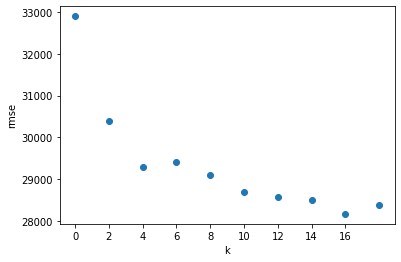

In [35]:
df = pd.read_csv('AmesHousing.tsv',delimiter='\t')
transform_df = transform_features(df)
filtered_df = select_features(transform_df)

kf = [x for x in range(0,20,2)]
rmses = []

for k_val in kf:
    rmses.append(train_and_test(filtered_df,k=k_val))
    
plt.scatter(x=kf,y=rmses)
plt.xlabel('k')
plt.ylabel('rmse')
plt.xticks(range(0,kf[-1],2))

The best result was acheived using 16 folds, however the model performance plateau's around 4 folds.

## Conclusion and Next Steps

In this project, we examined a dataset of home sales in Ames, Iowa and built a linear regression model to predict house sale prices

Some **feature engineering** and **feature selection** techniques were used to make and select the proper features for a Linear Regression Model.

When training and testing our model, holdout, simple, and cross validations with the Linear Regression model were applied.

The best result was achieved using k-fold cross validation with 16 number of folds, however model performance plateau's around 4 folds. Depending on the size of the dataset, I would recommend using 4 folds for smaller datasets and 14 for larger datasets.


### Next Steps

To continue improving this model, we can:

- Continue iteration on feature engineering: We can use domain knowledge to find more approaches to creating or using new features around housing data.
- Improve feature selection: We can research ways of doing feature selection better with categorical columns.